# Human Activity Recognition (HAR)

## Task 1: Exploratory Data Analysis on the HAR Dataset

### Importing libraries

In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tsfel
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import medfilt
from scipy.signal import butter, filtfilt

### Loading the dataset

In [238]:
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [239]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (126, 500, 3)
Shape of y_train: (126,)
Shape of X_test: (54, 500, 3)
Shape of y_test: (54,)


In [240]:
activity = {
        1: 'Walking',
        2: 'Walking Upstairs',
        3: 'Walking Downstairs',
        4: 'Sitting',
        5: 'Standing',
        6: 'Laying'
}

In [241]:
# Utility functions
def report_classification_results(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0) * 100
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0) * 100
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print("\nConfusion Matrix:")
    print(conf_matrix)

def pca_plot(original_features, title):
    """
        original_features: (n_samples, n_features)
        title: title of the PCA plot
    """
    scaler = StandardScaler()
    original_features_scaled = scaler.fit_transform(original_features)

    pca = PCA(n_components=2)
    results = pca.fit_transform(original_features_scaled)

    plt.figure(figsize=(10,8))
    unique_labels = np.unique(y)
    for lbl in unique_labels:
        idx = (y == lbl)
        plt.scatter(results[idx,0], results[idx,1], label=activity[lbl])

    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(title)
    plt.legend(title="Activity", loc="best")
    plt.grid(True)
    plt.show()

#### 1. Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data?

Based on the trends in the given time-series data, a machine learning model will be able to classify the activities (after capturing appropriate features).

In [242]:
examples = [6, 3, 16, 9 ,2,1]
for i in examples:
    print(activity[int(y_train[i])])

Walking
Walking Upstairs
Walking Downstairs
Sitting
Standing
Laying


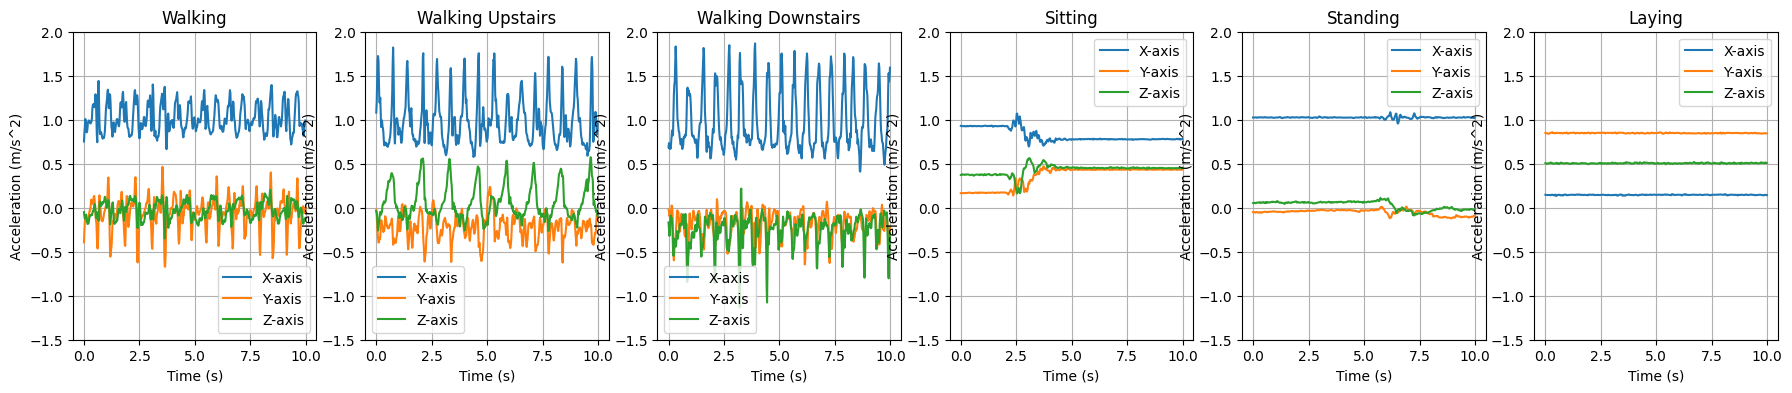

In [243]:
sampling_rate = 50
n_samples =  len(X_train[0]) # 500
time = np.arange(n_samples)/sampling_rate

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(22, 4))

for idx, i in enumerate(examples):
    axes[idx].plot(time, X_train[i][:, 0], label = 'X-axis')
    axes[idx].plot(time, X_train[i][:, 1], label = 'Y-axis')
    axes[idx].plot(time, X_train[i][:, 2], label = 'Z-axis')
    axes[idx].set_title(activity[int(y_train[i])])
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Acceleration (m/s^2)")
    axes[idx].set_ylim(-1.5, 2)
    axes[idx].legend()
    axes[idx].grid(True)
plt.show()

#### 2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2+acc_y^2+acc_z^2)$ for each activity and justify your answer.

We do not need a machine learning model to diffrentiate between static activities and dynamic activities. This is because in static activities, the linear acceleration values does not exceed beyond a particular bound [lower_bound, upper_bound]. A simple if-condition will suffice for this task.

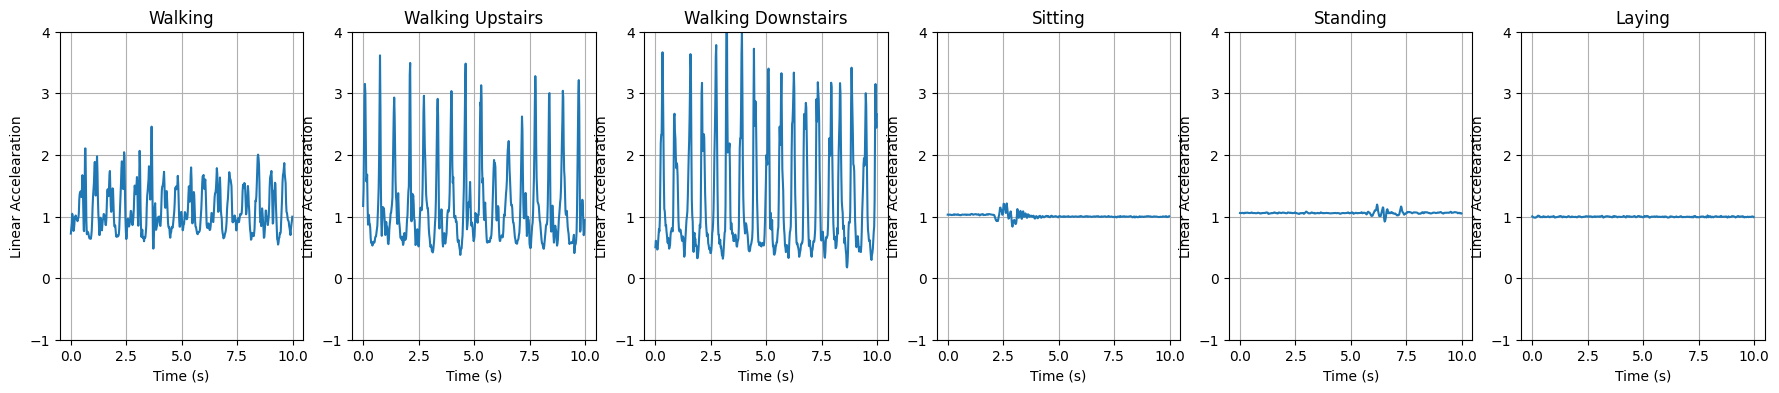

In [244]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(22, 4))
for idx, i in enumerate(examples):
    acc_x = X_train[i][:, 0]
    acc_y = X_train[i][:, 1]
    acc_z = X_train[i][:, 2]

    total_acceleration = np.pow(acc_x, 2) + np.pow(acc_y, 2) + np.pow(acc_z, 2)
    axes[idx].plot(time, total_acceleration)
    axes[idx].set_title(activity[int(y_train[i])])
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Linear Accelearation")
    axes[idx].set_ylim(-1, 4)
    axes[idx].grid(True)
plt.show()

#### 3. Visualize the data using PCA

a. Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities. 

In [245]:
total_accelerations = []
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

for sample in X:
    acc_x = sample[:, 0]
    acc_y = sample[:, 1]
    acc_z = sample[:, 2]
    t_acc = np.pow(acc_x, 2) + np.pow(acc_y, 2) + np.pow(acc_z, 2)
    total_accelerations.append(t_acc)
total_accelerations = np.array(total_accelerations)

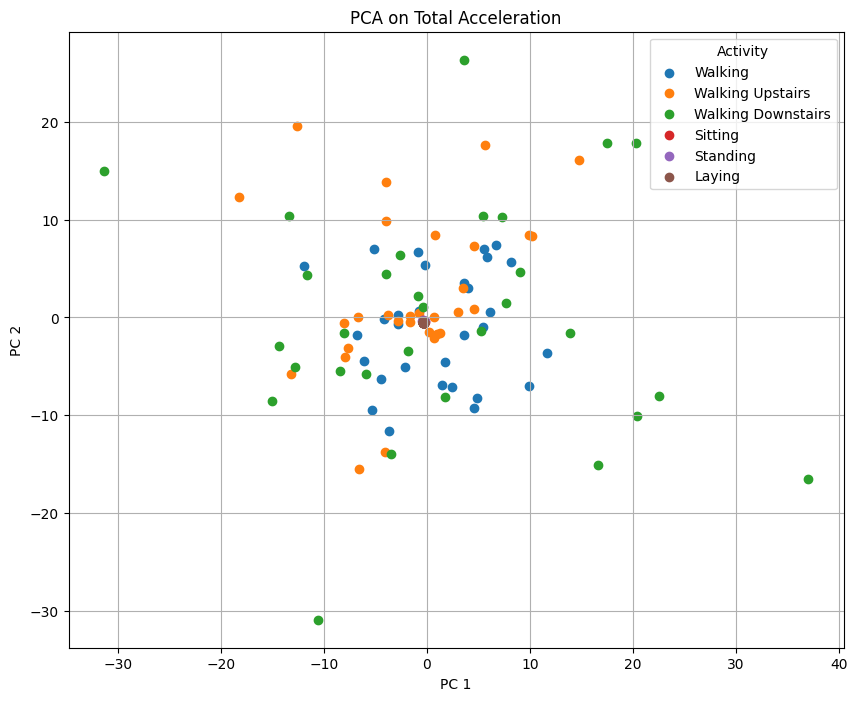

In [246]:
pca_plot(total_accelerations, "PCA on Total Acceleration")

b.  Next, use [TSFEL](https://tsfel.readthedocs.io/en/latest/) ([a featurizer library](https://github.com/fraunhoferportugal/tsfel)) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities. 

**Selected features**:
- Mean, Median, Standard Deviation, Variance, Skewness, Kurtosis, MAD, Peak to Peak distance, RMS
- Zero Crossing Rate, Autocorrelation, Slope, Signal Distance
- Spectral centroid, Spectral roll-off, Spectral spread, Maximum frequency, Median frequency, Spectral Entropy, Max Power Spectrum
- Absolute Energy, Average power

In [ ]:
cfg = tsfel.load_json("tsfel_features_1.json")
tsfel_features = tsfel.time_series_features_extractor(cfg, X)
print(f"Shape of tsfel_samples: {tsfel_features.shape}")

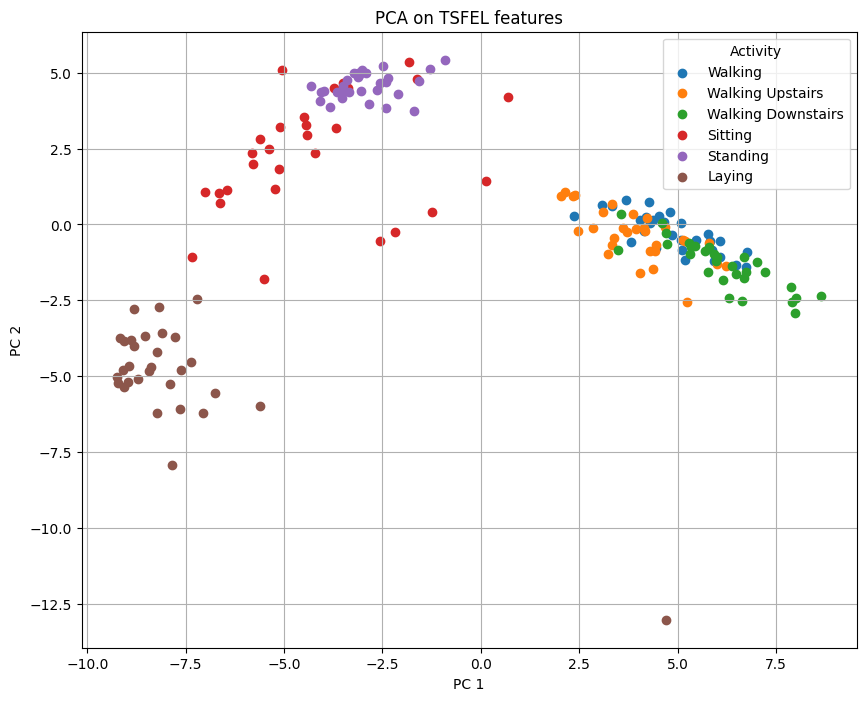

In [248]:
pca_plot(tsfel_features, "PCA on TSFEL features")

c. Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

**Features Provided by the dataset**:
- Mean, Standard Deviation, Median Absolute Deviation, Max/Min, *Signal Magnitude Area*, Energy, Interquartile Range (IQR), Entropy, *Autoregressive Coefficients*
- *Correlation(X, Y), Correlation(Y, Z), Correlation(X,Z)*
- Maximum frequency component index
- *Mean frequency*
- Skewness, Kurtosis
- *Bands Energy*

In [282]:
# Utility functions to compute features not available in TSFEL
def compute_signal_magnitude_area(data):
    sma = np.mean(np.sum(np.abs(data), axis=2), axis=1)
    df = pd.DataFrame(sma, columns=["Signal_Magnitude_Area"])
    return df

def compute_correlation_coeffs(data):
    n_samples = data.shape[0]
    cols = ["Correlation-0,1", "Correlation-1,2", "Correlation-2,0"]
    corrs = np.zeros((n_samples, 3))

    for i in range(n_samples):
        X = data[i, :, 0]
        Y = data[i, :, 1]
        Z = data[i, :, 2]
        corrs[i, 0] = np.corrcoef(X, Y)[0, 1]
        corrs[i, 1] = np.corrcoef(Y, Z)[0, 1]
        corrs[i, 2] = np.corrcoef(Z, X)[0, 1]

    df = pd.DataFrame(corrs, columns=cols)
    return df

In [ ]:
cfg = tsfel.load_json("tsfel_features_2.json")
har_features = tsfel.time_series_features_extractor(cfg, X, fs=50)

sma_df = compute_signal_magnitude_area(X)
har_features = pd.concat([har_features, sma_df], axis = 1)

corr_coeff_df = compute_correlation_coeffs(X)
har_features = pd.concat([har_features, corr_coeff_df], axis = 1)

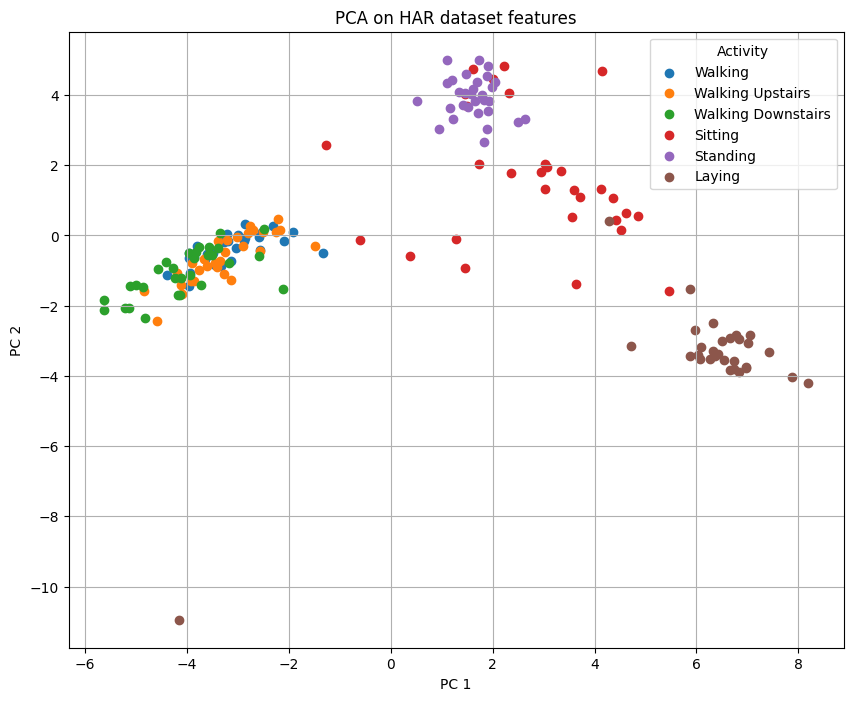

In [284]:
pca_plot(har_features, "PCA on HAR dataset features")

d. Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data?

**Comparision of PCA Results:**
- The results of our PCA shows that adopting only the Total Accelearation value gives a very poor diffrentiation among activities.
- PCA based on TSFEL and HAR dataset features shows that activities of standing, sitting, and laying are well differentiatied.\
But, they still have difficulty diffrentiating among the dyanamic activities.
- PCA based on TSFEL and HAR dataset features also leads to a roughly similar plot.

#### 4. Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features?

a. Correlation Matrix of TSFEL features.

**Observations:**
- Absolute Energy, Average Power, Mean, Median, and RMS shows strong correlations.
- Spectral centroid and Spectral roll-off are correlated.
- Higher correlations indicate redundancies.


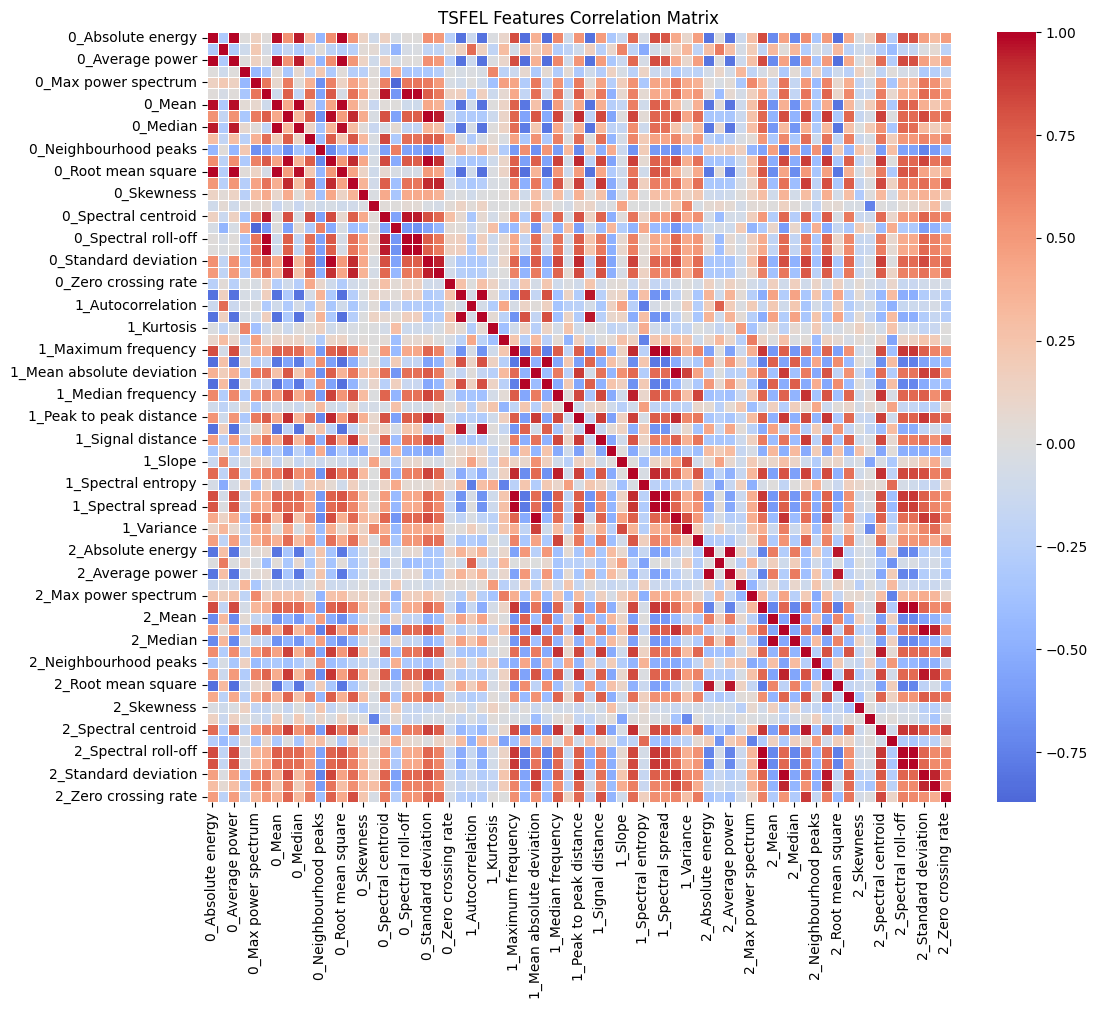

In [285]:
tsfel_correlation_matrix = tsfel_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(tsfel_correlation_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("TSFEL Features Correlation Matrix")
plt.show()

b. Correlation Matrix of HAR dataset features.

**Observations:**
- Comparatively lower correlation among features.

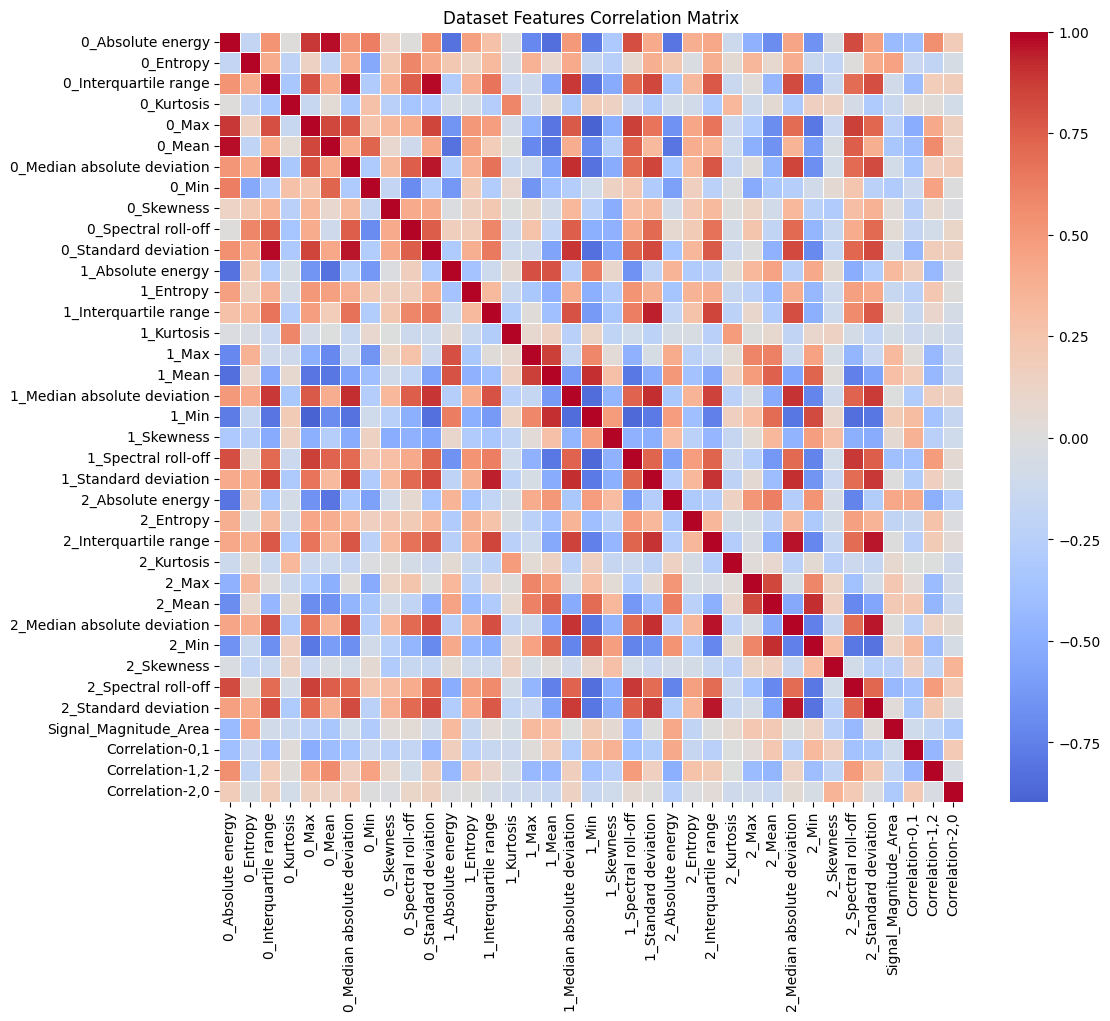

In [295]:
har_correlation_matrix = har_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(har_correlation_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Dataset Features Correlation Matrix")
plt.show()

## Task 2: Decision Trees for Human Activity Recognition

#### 1. Use Sklearn Library to train Decision Trees.

a. Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.

In [296]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [297]:
raw_accelerometer_clf = DecisionTreeClassifier(max_depth=8, random_state=42)
raw_accelerometer_clf.fit(X_train_reshaped, y_train)
y_pred = raw_accelerometer_clf.predict(X_test_reshaped)
report_classification_results(y_test, y_pred)

Accuracy: 53.70%
Precision: 55.67%
Recall: 53.70%

Confusion Matrix:
[[1 3 0 3 2 0]
 [2 4 1 1 1 0]
 [3 3 2 1 0 0]
 [0 0 0 8 1 0]
 [0 0 0 2 7 0]
 [0 0 0 2 0 7]]


b. Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model.

In [ ]:
cfg = tsfel.load_json("tsfel_features_1.json")
tsfel_X_train = tsfel.time_series_features_extractor(cfg, X_train, fs=50)
tsfel_X_test = tsfel.time_series_features_extractor(cfg, X_test, fs=50)

In [299]:
print(f"Shape of tsfel_X_train: {tsfel_X_train.shape}")
print(f"Shape of tsfel_X_test: {tsfel_X_test.shape}")

Shape of tsfel_X_train: (126, 69)
Shape of tsfel_X_test: (54, 69)


In [300]:
scaler = StandardScaler()
tsfel_X_train_scaled = scaler.fit_transform(tsfel_X_train)
tsfel_X_test_scaled = scaler.fit_transform(tsfel_X_test)
tsfel_features_clf = DecisionTreeClassifier(max_depth=8, random_state=42)
tsfel_features_clf.fit(tsfel_X_train_scaled, y_train)

y_pred = tsfel_features_clf.predict(tsfel_X_test_scaled)
report_classification_results(y_test, y_pred)

Accuracy: 90.74%
Precision: 91.06%
Recall: 90.74%

Confusion Matrix:
[[8 0 1 0 0 0]
 [1 7 1 0 0 0]
 [0 1 8 0 0 0]
 [0 0 0 8 1 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]


c. Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model.

In [301]:
cfg = tsfel.load_json("tsfel_features_2.json")
har_X_train = tsfel.time_series_features_extractor(cfg, X_train, fs=50)
har_X_test = tsfel.time_series_features_extractor(cfg, X_test, fs=50)

sma_X_train_df = compute_signal_magnitude_area(X_train)
sma_X_test_df = compute_signal_magnitude_area(X_test)
har_X_train = pd.concat([har_X_train, sma_X_train_df], axis = 1)
har_X_test = pd.concat([har_X_test, sma_X_test_df], axis = 1)

corr_coeff_X_train_df = compute_correlation_coeffs(X_train)
corr_coeff_X_test_df = compute_correlation_coeffs(X_test)
har_X_train = pd.concat([har_X_train, corr_coeff_X_train_df], axis = 1)
har_X_test = pd.concat([har_X_test, corr_coeff_X_test_df], axis = 1)

In [302]:
print(f"Shape of har_X_train: {har_X_train.shape}")
print(f"Shape of har_X_test: {har_X_test.shape}")

Shape of har_X_train: (126, 37)
Shape of har_X_test: (54, 37)


In [303]:
scaler = StandardScaler()
har_X_train_scaled = scaler.fit_transform(har_X_train)
har_X_test_scaled = scaler.fit_transform(har_X_test)
har_features_clf = DecisionTreeClassifier(max_depth=8, random_state=42)
har_features_clf.fit(har_X_train_scaled, y_train)

y_pred = har_features_clf.predict(har_X_test_scaled)
report_classification_results(y_test, y_pred)

Accuracy: 81.48%
Precision: 83.54%
Recall: 81.48%

Confusion Matrix:
[[7 0 2 0 0 0]
 [1 5 3 0 0 0]
 [1 1 7 0 0 0]
 [0 0 0 7 2 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]


d. Compare the results of the three models. Which model do you think is better?
- In my implementation, the second model trained using selected TSFEL features gives the best overall performance.
- The model trained on HAR features suffers because of redundancies in the features.

#### 2. Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree.

a. Total Acceleration

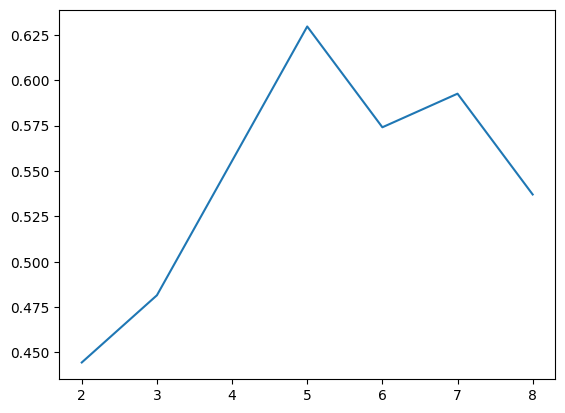

In [304]:
accuracy_scores = []
depths = []

for depth in range(2, 9):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train_reshaped, y_train)
    y_pred = clf.predict(X_test_reshaped)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    depths.append(depth)
plt.plot(depths, accuracy_scores)
plt.show()

b. TSFEL features

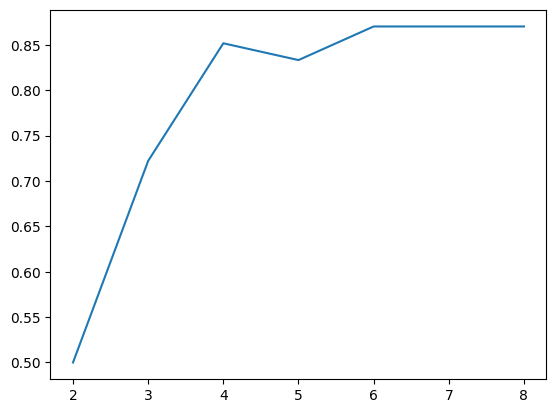

In [305]:
accuracy_scores = []
depths = []

for depth in range(2, 9):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(tsfel_X_train, y_train)
    y_pred = clf.predict(tsfel_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    depths.append(depth)
plt.plot(depths, accuracy_scores)
plt.show()

c. HAR features

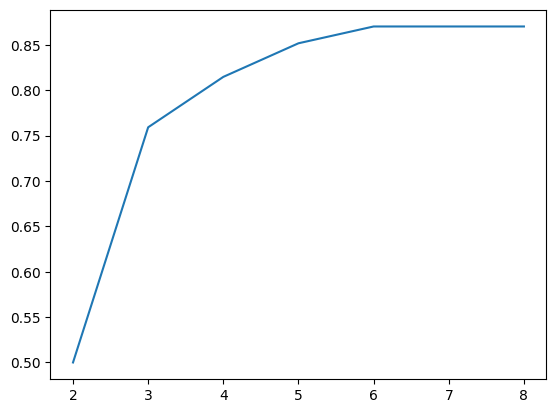

In [306]:
accuracy_scores = []
depths = []

for depth in range(2, 9):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(har_X_train, y_train)
    y_pred = clf.predict(har_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    depths.append(depth)
plt.plot(depths, accuracy_scores)
plt.show()

#### 3. Are there any participants/ activitivies where the Model performace is bad? If Yes, Why?

**Activities with poor model performance:**

As we can observe in our confusion matrices, all three models (raw accelerometer data model, TSFEL features model & HAR features model)\
struggle to differentiate between the activities of WALKING, WALKING_UPSTAIRS and WALKING_DOWNSTAIRS.

## Task 3: Data Collection in the Wild

**Data Collection Process**:
- 3 samples were collected for each activity (Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying) using the **Pysics Toolbox Suite** \
 application under the same configuration(phone placement, device etc.)
- Each sample consists of **~15 seconds** of data collected at a sampling rate of **100Hz**. The data is then **downsampled to 50Hz**. 
- With an offset of 2.5 seconds from the initial timestamp, the next 10 seconds of data are kept.
- Activities of Standing and Sitting are done at the middle of the recording.
- Following the procedure of the HAR dataset creation pipeline, the signals are first filtered using a median filter (removes impulse noise/spikes)\
 and a 3rd order low pass Butterworth filter with a corner frequency of 20Hz(removes high frequency noise).
- Since our earlier models where trained on the total acceleration signals, no separation of body and gravity acceleration is done.

In [267]:
X_custom = np.load("X_custom.npy")
y_custom = np.load("y_custom.npy")
print(f"Shape of X_custom: {X_custom.shape}")
print(f"Shape of y_custom: {y_custom.shape}")

Shape of X_custom: (18, 500, 3)
Shape of y_custom: (18,)


#### Median Filtering and Low Pass Butterworth Filtering

In [268]:
fs = 50 
cutoff = 20

def butter_lowpass_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

for i in range(len(X_custom)):
    sample = X_custom[i]
    acc_x = sample[:, 0]
    acc_y = sample[:, 1]
    acc_z = sample[:, 2]
    acc_x_filtered = medfilt(acc_x, kernel_size=3)
    acc_y_filtered = medfilt(acc_y, kernel_size=3)
    acc_z_filtered = medfilt(acc_z, kernel_size=3)

    acc_x_clean = butter_lowpass_filter(acc_x_filtered, cutoff, fs)
    acc_y_clean = butter_lowpass_filter(acc_y_filtered, cutoff, fs)
    acc_z_clean = butter_lowpass_filter(acc_z_filtered, cutoff, fs)
    
    X_custom[i] = np.vstack([acc_x_clean, acc_y_clean, acc_z_clean]).T

Let us plot a sample for each of the activities from our custom dataset.

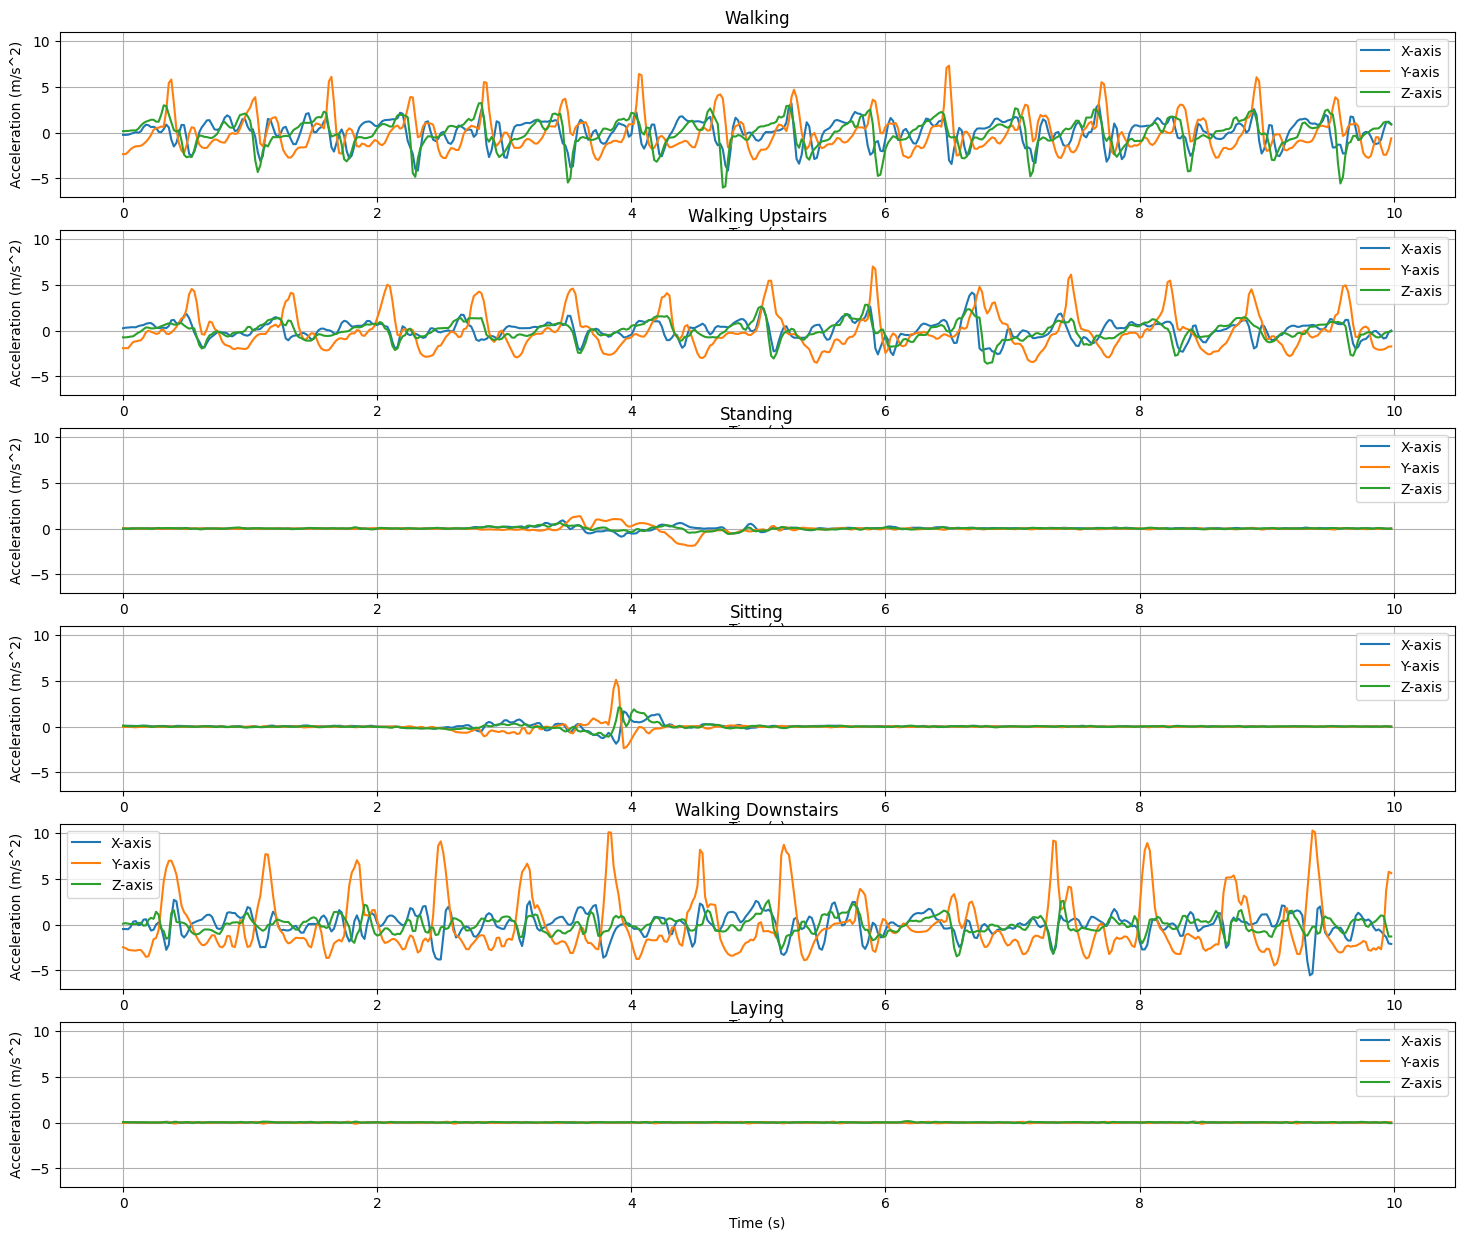

In [269]:
examples = [1, 5, 7, 11, 12, 15]
sampling_rate = 50
n_samples =  len(X_custom[0])
time = np.arange(n_samples)/sampling_rate

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(18, 15))

for idx, i in enumerate(examples):
    axes[idx].plot(time, X_custom[i][:, 0], label = 'X-axis')
    axes[idx].plot(time, X_custom[i][:, 1], label = 'Y-axis')
    axes[idx].plot(time, X_custom[i][:, 2], label = 'Z-axis')
    axes[idx].set_title(activity[int(y_custom[i])])
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Acceleration (m/s^2)")
    axes[idx].set_ylim(-7, 11)
    axes[idx].legend()
    axes[idx].grid(True)
plt.show()

#### 1. Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? [1 marks]

Let us test the **model trained on TSFEL features** (which gave us the best overall performance) on our custom dataset.

In [ ]:
cfg = tsfel.load_json("tsfel_features_1.json")
X_custom_tsfel = tsfel.time_series_features_extractor(cfg, X_custom)
print(f"Shape of tsfel_samples: {X_custom_tsfel.shape}")

In [271]:
scaler = StandardScaler()
X_custom_tsfel_scaled = scaler.fit_transform(X_custom_tsfel)
y_pred = tsfel_features_clf.predict(X_custom_tsfel_scaled)
report_classification_results(y_custom, y_pred)

Accuracy: 72.22%
Precision: 68.33%
Recall: 72.22%

Confusion Matrix:
[[0 3 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 2 1 0]
 [0 0 0 0 0 3]]


#### 2. Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform?

**Preprocessing:**
- Downsampling from 100Hz to 50 Hz
- Median Filtering
- Low-Pass Butterworth filtering

**Featurization:**\
The following features are selected using TSFEL.
- Mean, Median, Standard Deviation, Variance, Skewness, Kurtosis, MAD, Peak to Peak distance, RMS
- Zero Crossing Rate, Autocorrelation, Slope, Signal Distance
- Spectral centroid, Spectral roll-off, Spectral spread, Maximum frequency, Median frequency, Spectral Entropy, Max Power Spectrum
- Absolute Energy, Average power


In [280]:
cX_train, cX_test, cy_train, cy_test = train_test_split(X_custom, y_custom, test_size=8, random_state=42)

print(f"Shape of cX_train: {cX_train.shape}")
print(f"Shape of cX_test: {cX_test.shape}")
print(f"Shape of cy_train: {cy_train.shape}")
print(f"Shape of cy_test: {cy_test.shape}")

Shape of cX_train: (10, 500, 3)
Shape of cX_test: (8, 500, 3)
Shape of cy_train: (10,)
Shape of cy_test: (8,)


Let us train a decision tree based on TSFEL features.

In [ ]:
cfg = tsfel.load_json("tsfel_features_1.json")
tsfel_cX_train = tsfel.time_series_features_extractor(cfg, cX_train, fs=50)
tsfel_cX_test = tsfel.time_series_features_extractor(cfg, cX_test, fs=50)

In [278]:
print(f"Shape of tsfel_cX_train: {tsfel_cX_train.shape}")
print(f"Shape of tsfel_cX_test: {tsfel_cX_test.shape}")

Shape of tsfel_cX_train: (10, 69)
Shape of tsfel_cX_test: (8, 69)


In [279]:
scaler = StandardScaler()
tsfel_cX_train_scaled = scaler.fit_transform(tsfel_cX_train)
tsfel_cX_test_scaled = scaler.fit_transform(tsfel_cX_test)
clf_1 = DecisionTreeClassifier(max_depth=8, random_state=42)
clf_1.fit(tsfel_cX_train_scaled, cy_train)

cy_pred = tsfel_features_clf.predict(tsfel_cX_test_scaled)
report_classification_results(cy_test, cy_pred)

Accuracy: 62.50%
Precision: 50.00%
Recall: 62.50%

Confusion Matrix:
[[0 2 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 2]]
